# EOF Analysis of NEMO surface tracers

***

In [26]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.dates as mdates
from cmocean import cm
from datetime import datetime, timedelta
from dateutil.parser import parse
from scipy import signal
from scipy.fftpack import fft, fftshift
from tqdm import tqdm_notebook as tqdm
from salishsea_tools import viz_tools, places

%matplotlib inline

***

## Load data

Daterange and boilerplate netCDF objects

In [4]:
# Daterange
daterange = [datetime(2015, 1, 15), datetime(2019, 1, 1)]

In [6]:
# Load NEMO netCDF files (concatentated using NCO)
ptrc = xr.open_dataset('/ocean/bmoorema/research/MEOPAR/analysis-ben/data/SalishSeaCast/SalishSea_1h_20150101_20181231_ptrc_T.nc')
mask = xr.open_dataset('/data/bmoorema/MEOPAR/grid/mesh_mask201702.nc')
coords = xr.open_dataset('/data/bmoorema/MEOPAR/grid/coordinates_seagrid_SalishSea201702.nc', decode_times=False)
tindex = [abs(ptrc.time_counter.values.astype('datetime64[s]').astype(datetime)-date).argmin()+1 for date in daterange]

# Load HRDPS netCDF files from ERDDAP at Sentry Shoal
j, i = places.PLACES['Sentry Shoal']['GEM2.5 grid ji']
HRDPS = xr.open_dataset('https://salishsea.eos.ubc.ca/erddap/griddap/ubcSSaSurfaceAtmosphereFieldsV1')
HRDPS = HRDPS.sel(time=slice(*daterange)).isel(gridY=j, gridX=i)

Load NEMO tracers into memory and flatten (in prep for PCA)

In [7]:
# Characterize subgrid (ptrc subdomain from NEMO NCO processing)
xrange, yrange, skip = [115, 361], [310, 789], 5
gridx, gridy = np.meshgrid(ptrc.x[::skip], ptrc.y[::skip])
shape = gridx.shape
npoints = np.prod(shape)

# Construct flattened variables
tmask = mask.tmask[0, 0, slice(*yrange), slice(*xrange)].values[::skip, ::skip].reshape(npoints).astype(bool)
gridx = gridx.reshape(npoints)[tmask]
gridy = gridy.reshape(npoints)[tmask]
nitrate = ptrc.nitrate[:, 0, ...].values[:, ::skip, ::skip].reshape(-1, npoints)[:, tmask]

Load HRDPS from ERDDAP into memory in ~6 month (4341 h) chunks

In [8]:
# Load netCDF data from ERDDAP in 6 month chunks
time, u, v = np.empty(0), np.empty(0), np.empty(0)
hours, chunk = int(np.diff(daterange)[0].total_seconds() / 3600), 4341
for hour in tqdm(range(0, hours, chunk)):
    dateslice = slice(*[daterange[0] + timedelta(hours=h) for h in (hour, hour + chunk - 1)])
    time = np.concatenate((time, HRDPS.time.sel(time=dateslice).values.astype('datetime64[s]').astype(datetime)))
    u = np.concatenate((u, HRDPS.u_wind.sel(time=dateslice).values))
    v = np.concatenate((v, HRDPS.v_wind.sel(time=dateslice).values))

# Process wind
mag = np.sqrt(u**2 + v**2)
angle = 180 * (1 - (np.arctan2(v, u) + np.arctan(2)) / np.pi) + 22
mag_axis = mag * np.cos(np.deg2rad(angle))

***

## Filtering

### Nitrate power spectral density (PSD)

First look at the surface nitrate PSD at selected coastal stations.

In [9]:
# Define coastal stations
stations = [
    {'name': 'Campbell River', 'loc': (720, 125), 'c': 'r'},
    {'name': 'Boundary Bay'  , 'loc': (360, 305), 'c': 'darkorange'},
    {'name': 'Qualicum'      , 'loc': (560, 165), 'c': 'gold'},
    {'name': 'Sunshine Coast', 'loc': (535, 250), 'c': 'darkslategray'},
]

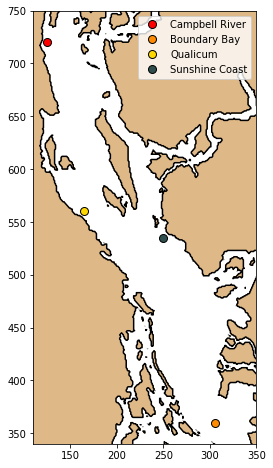

In [10]:
# Plot coastal stations
fig, ax = plt.subplots(figsize=(4, 8))
ax.set_xlim([110, 350])
ax.set_ylim([340, 750])
viz_tools.set_aspect(ax)
for attr, color in zip(['contourf', 'contour'], ['Burlywood', 'k']):
    getattr(ax, attr)(mask.x, mask.y, mask.tmask[0, 0, ...], levels=[-0.01, 0.01], colors=color)
for station in stations:
    ax.plot(*station['loc'][::-1], 'ko', markerfacecolor=station['c'], markersize=8, label=station['name'])
ax.legend()
plt.show()

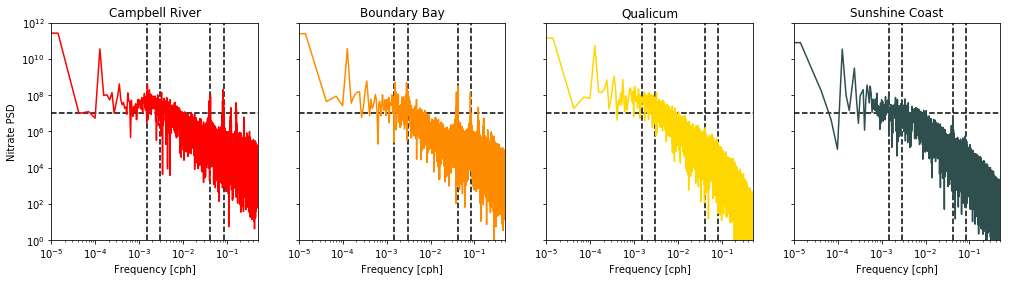

In [11]:
# Plot surface nitrate PSD at coastal stations
xlim, ylim, n = [1e-5, 1/2], [1, 1e12], nitrate.shape[0]
freq = np.linspace(-1/2, 1/2, n)
peaks = [12, 24, 24*14, 24*28]
fig, axs = plt.subplots(1, 4, figsize=(17, 4))
for ax, station in zip(axs, stations):
    ax.plot(xlim, [1e7, 1e7], 'k--')
    for peak in peaks:
        ax.plot([1 / peak, 1 / peak], ylim, 'k--')
    index = ((gridy == station['loc'][0] - yrange[0]) & (gridx == station['loc'][1] - xrange[0])).argmax()
    PSD = abs(fftshift(fft(nitrate[:, index])))**2
    ax.plot(freq, PSD, '-', color=station['c'])
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_xlabel('Frequency [cph]')
    ax.set_title(station['name'])
    if station['name'] == 'Campbell River': ax.set_ylabel('Nitrate PSD')
    else: ax.yaxis.set_ticklabels('')

***

### Attenuation spectra of FIR moving average filter windows

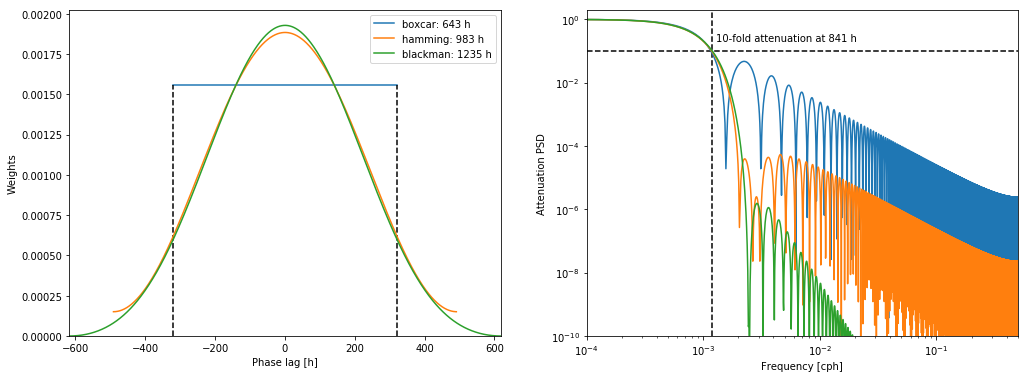

In [12]:
# Define parameters
cutoff = 841
freq = np.linspace(-1/2, 1/2, n)
W = (cutoff / 2 * np.array([0.765, 1.168, 1.468])).astype('int') * 2 + 1
order = 10**(np.floor(np.log10(1 / cutoff)) - 1)

# Make plots
fig, axs = plt.subplots(1, 2, figsize=(17, 6))
lims = [(-max(W)/2, max(W)/2, 0, 2.5/max(W)), (order, 1/2, 1e-10, 2)]
labels = [(f'Phase lag [h]', 'Weights'), ('Frequency [cph]', 'Attenuation PSD')]
axs[1].set_xscale('log')
axs[1].set_yscale('log')
axs[1].plot([1/cutoff, 1/cutoff], lims[1][2:], 'k--')
axs[1].plot(lims[1][:2], [0.1, 0.1], 'k--')
axs[1].text(1/cutoff + order, 0.2, f'10-fold attenuation at {cutoff} h')
for ax, lim, label in zip(axs, lims, labels):
    ax.set_xlim(lim[:2])
    ax.set_ylim(lim[2:])
    ax.set_xlabel(label[0])
    ax.set_ylabel(label[1])

# Plot filters
for window_type, w in zip(['boxcar', 'hamming', 'blackman'], W):
    w2 = (w - 1) / 2
    window = signal.get_window(window_type, w)
    window = window / sum(window)
    PSD = abs(fftshift(fft(window, n)))**2
    axs[0].plot(np.linspace(-w2, w2, w), window, label=f'{window_type}: {np.round(w):.0f} h')
    axs[1].plot(freq, PSD)
    if window_type is 'boxcar':
        [axs[0].plot([fac*w2, fac*w2], [0, window[0]], 'k--') for fac in [-1, 1]]

axs[0].legend()
plt.show()

***

### Apply selected filter windows to surface nitrate

Since we are subtracting the lowpass filter data, we want to preserve as much high frequency signal as possible (i.e. small sidelobes are more important than steep cutoff). We thus choose the Blackman filter.

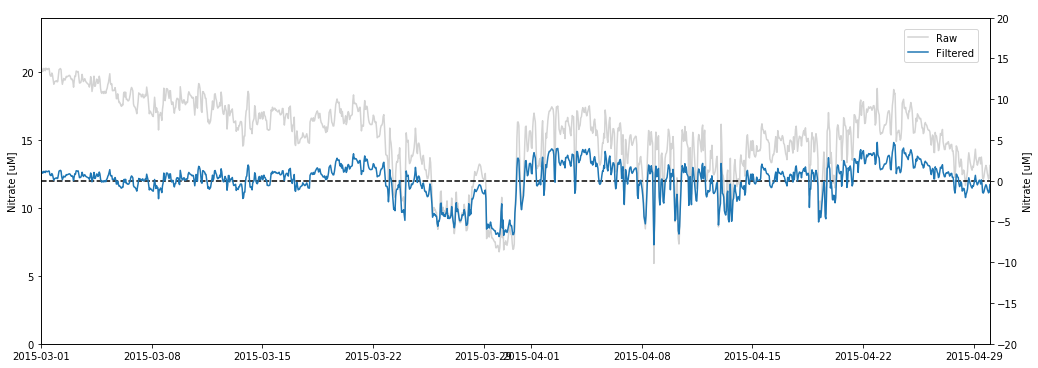

In [14]:
# Make figure
xlim = [datetime(2015, 3, 1), datetime(2015, 4, 30)]
fig, ax = plt.subplots(figsize=(17, 6))
ax.plot(ptrc.time_counter.values, nitrate[:, 0], '-', color='lightgray', label='Raw')
ax.set_xlim(xlim)
ax.set_ylim([0, 24])
ax.set_ylabel('Nitrate [uM]')
ax2 = ax.twinx()
ax2.plot(xlim, [0, 0], 'k--')
ax2.set_ylim([-20, 20])
ax2.set_ylabel('Nitrate [uM]')

# Calculate bandpass as difference between windows
window_type, w = 'blackman', 1235
nitrate_highpass = {}
window = signal.get_window(window_type, w)
window = window / sum(window)
nitrate_highpass[window_type] = np.empty(nitrate.shape)
for i, loc in zip(tqdm(range(nitrate.shape[1])), nitrate.T):
    nitrate_highpass[window_type][:, i] = loc - signal.convolve(loc, window, mode='same')
ax2.plot(ptrc.time_counter.values, nitrate_highpass[window_type][:, 0], label='Filtered')
fig.legend(loc=(0.87, 0.83))
plt.show()

***

## Calculate EOF

In [15]:
def varimax(A, maxiter=30, tol=1e-5):
    """From Horst 1965
    with modifications from Ben FrantzDale on Wikipedia talkpage
    https://en.wikipedia.org/wiki/Talk:Varimax_rotation
    """
    
    n, p = A.shape
    H = np.eye(p)
    d = 0
    convergence = []
    for i in tqdm(range(maxiter)):
        d_old = d
        B = A.dot(H)  # -------------------------------------------------------- 18.4.5
        beta = B * B * B - B.dot(np.diag(np.diag(B.T.dot(B)))) / n  # ---------- 18.4.1
        C = A.T.dot(beta)  # --------------------------------------------------- 18.4.2
        u, s, vh = np.linalg.svd(C)  # -- 18.4.3 (modified by Ben FrantzDale (Wikipedia) to use SVD)
        H = u.dot(vh)  # ---------------- 18.4.4 (modified by Ben FrantzDale (Wikipedia))
        d = sum(s)
        convergence.append(d)
        if d_old != 0 and d/d_old < 1 + tol: break
    return H, convergence

In [16]:
# Extract winter
z = np.empty((0, 1833))
w = np.empty(0)
t = np.empty(0)
for year in range(2015, 2019):
    start, end = [abs(time - datetime(year, month, 1)).argmin() for month in [3, 10]]
    t = np.concatenate((t, time[start: end]))
    z = np.concatenate((z, nitrate_highpass['blackman'][slice(*tindex), :][start: end, :]), axis=0)
    w = np.concatenate((w, mag_axis[start: end]))
z = z - z.mean(axis=0)[np.newaxis, :]

In [17]:
# EOF analysis
EOF = {}
A_prime, sqrtL, E_T = np.linalg.svd(z, full_matrices=False)
EOF['A'] = A_prime.dot(np.diag(sqrtL))
A2 = EOF['A'] * EOF['A']
EOF['var'] = A2.sum(axis=0) / A2.sum()
EOF['E'] = E_T.T

In [18]:
# Get varimax rotation matrix
R, convergence = varimax(EOF['A'])

# Rotate matrices
EOF['B'] = EOF['A'].dot(R)
B2 = EOF['B'] * EOF['B']
EOF['var_rot'] = B2.sum(axis=0) / B2.sum()
EOF['U'] = EOF['E'].dot(R)

***

## Plot EOFs

In [19]:
def plot_EOF(EOF):
    """Plot EOFs
    """
    
    # Make figure and plotting params
    fig, axs = plt.subplots(4, 5, figsize=(17, 20), gridspec_kw={'hspace': 0.05, 'height_ratios': [1, 3, 1, 3]})
    plotx, ploty = mask.x[slice(*xrange, 5)], mask.y[slice(*yrange, 5)]
    xlim, ylim = [1e-4, 1/2], [1, 1e11]
    freq = np.linspace(-1/2, 1/2, EOF['A'].shape[0])
    
    # Plot PCs
    for row, PC, var in zip([0, 2], ['A', 'B'], ['var', 'var_rot']):
        for ax, mode in zip(axs[row, :], range(5)):
            for peak in [24, 24*12]: ax.plot([1/peak, 1/peak], ylim, 'c--')
            PSD = abs(fftshift(fft(EOF[PC][:, mode])))**2
            ax.plot(freq, PSD, 'k-')
            ax.set_xscale('log')
            ax.set_yscale('log')
            ax.set_xlim(xlim)
            ax.set_ylim(ylim)
            ax.text(0.02, 0.05, f'{EOF[var][mode]*100:.01f}% variance', transform=ax.transAxes)
            if mode == 0: ax.set_ylabel('PC PSD')
            else: ax.yaxis.set_ticklabels('')
            if row == 0: ax.set_title(f'Mode {mode}')

    # Plot EOFs
    for row, eof in zip([1, 3], ['E', 'U']):
        for ax, mode in zip(axs[row, :], range(5)):
            gridded = np.zeros(ptrc.nav_lon.shape)
            for y, x, val in zip(gridy, gridx, EOF[eof][:, mode]): gridded[y, x] = val
            ax.contourf(plotx, ploty, gridded[::skip, ::skip], levels=np.arange(-0.1, 0.101, 0.001), cmap=cm.balance, extend='both')
            ax.contourf(mask.x, mask.y, mask.tmask[0, 0, ...], levels=[-0.01, 0.01], colors='Burlywood')
            ax.contour(mask.x, mask.y, mask.tmask[0, 0, ...], levels=[-0.01, 0.01], colors='k')
            viz_tools.set_aspect(ax)
            ax.set_xlim(xrange)
            ax.set_ylim(yrange)
            if mode != 0: ax.yaxis.set_ticklabels('')

    # Add final labels
    for ypos, text in zip([0.43, 0.81], ['Rotated', 'Non-rotated']):
        fig.text(0.128, ypos, text, fontdict={'size': 16, 'weight': 'bold'})

***

### 35 day cutoff vs wind (12-day lag)

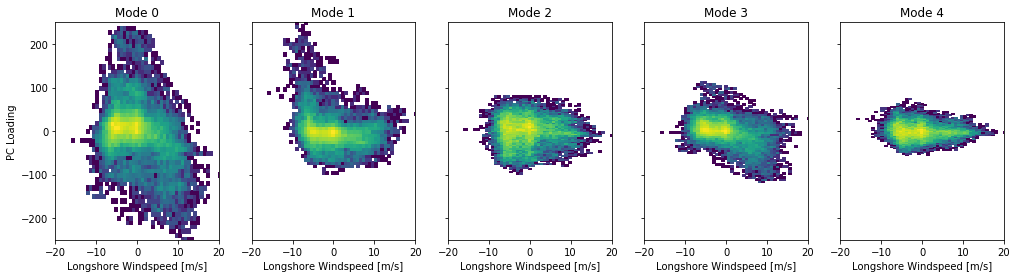

In [21]:
fig, axs = plt.subplots(1, 5, figsize=(17, 4))
lag = 12
for ax, mode in zip(axs, range(5)):
    ax.hist2d(w[:-lag], EOF['B'][lag:, mode], bins=50, norm=mcolors.LogNorm())
    ax.set_xlim([-20, 20])
    ax.set_ylim([-250, 250])
    ax.set_title(f'Mode {mode}')
    ax.set_xlabel('Longshore Windspeed [m/s]')
    if mode == 0:
        ax.set_ylabel('PC Loading')
    else:
        ax.yaxis.set_ticklabels('')

***

### 7 day cutoff

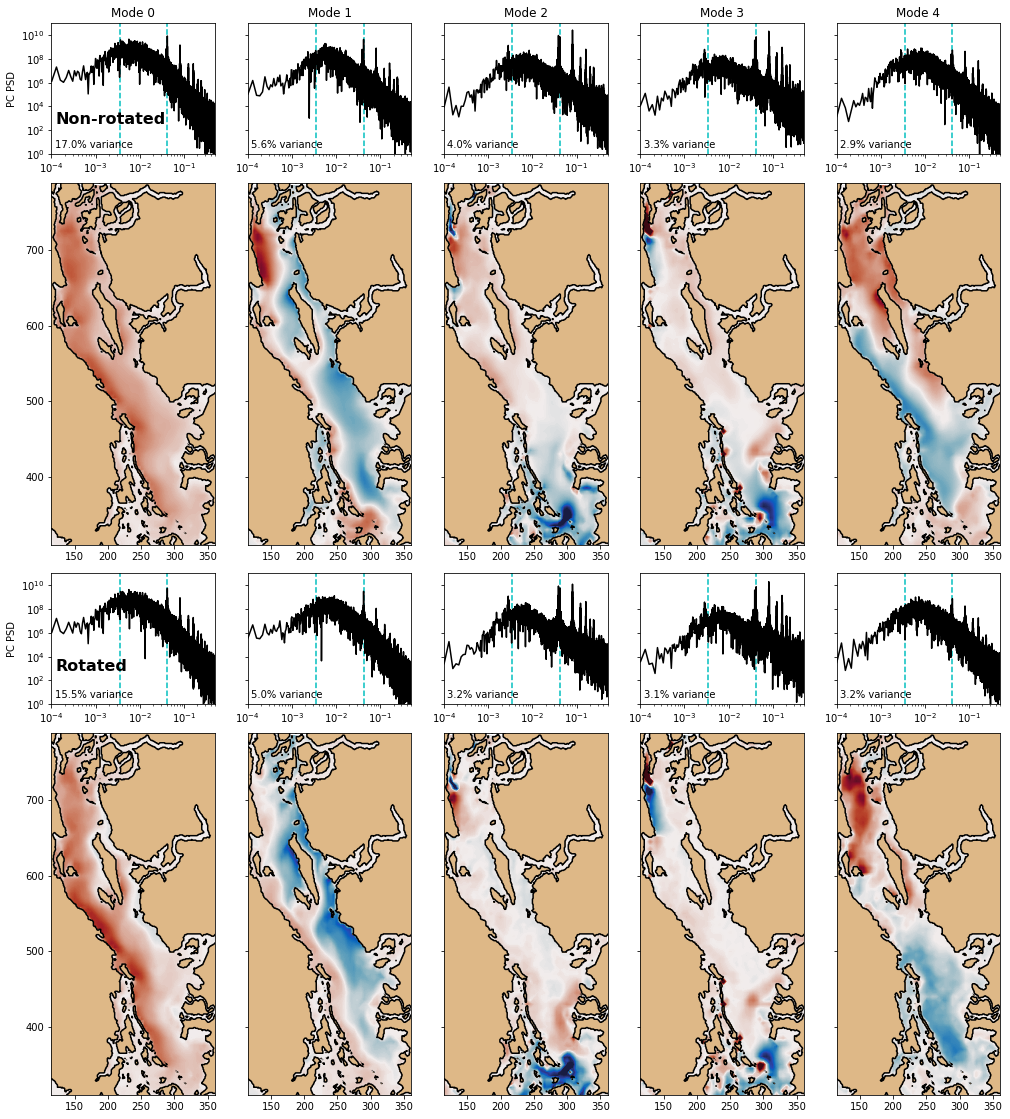

In [26]:
# 7 day cutoff
plot_EOF(EOF)

### 14 day cutoff

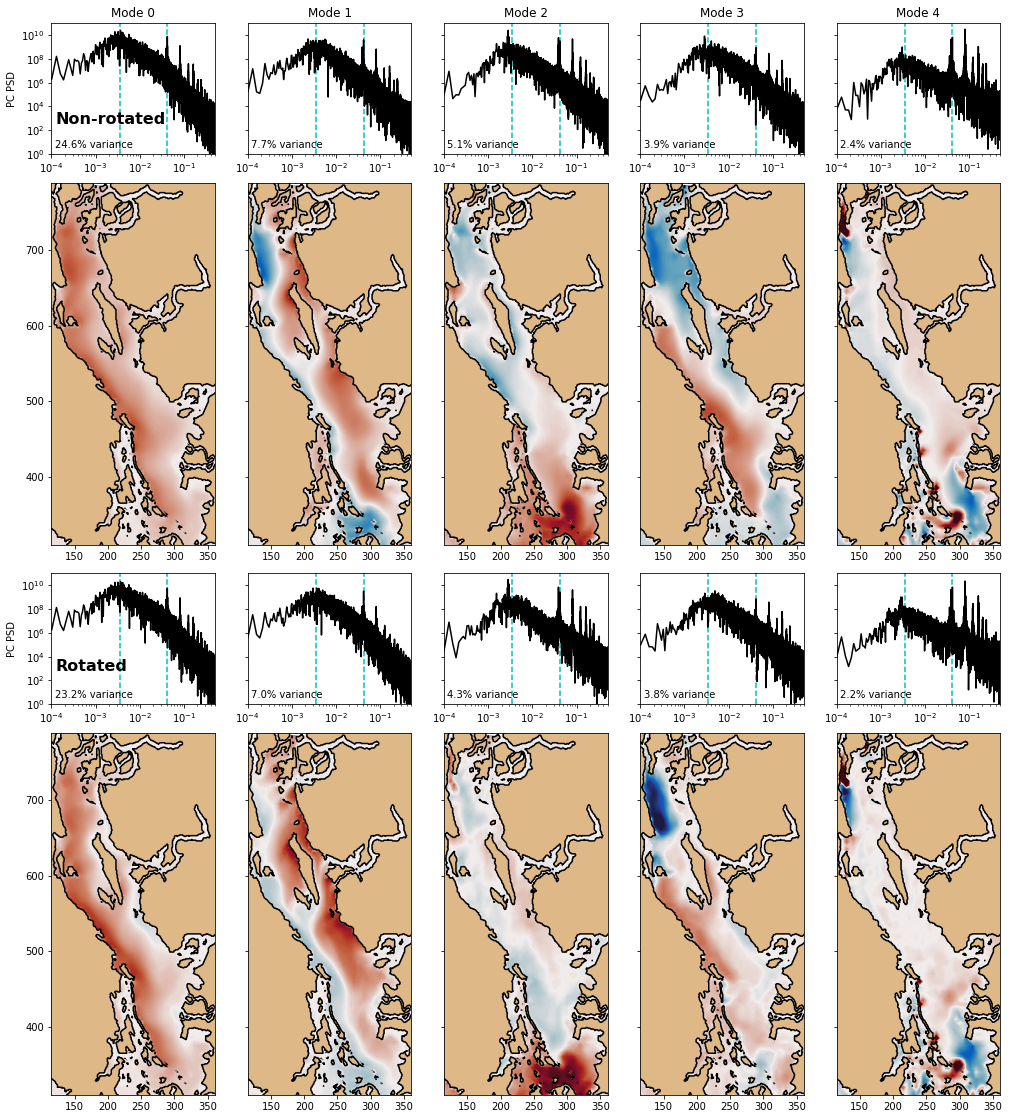

In [31]:
# 14 day cutoff
plot_EOF(EOF)

### 21 day cutoff

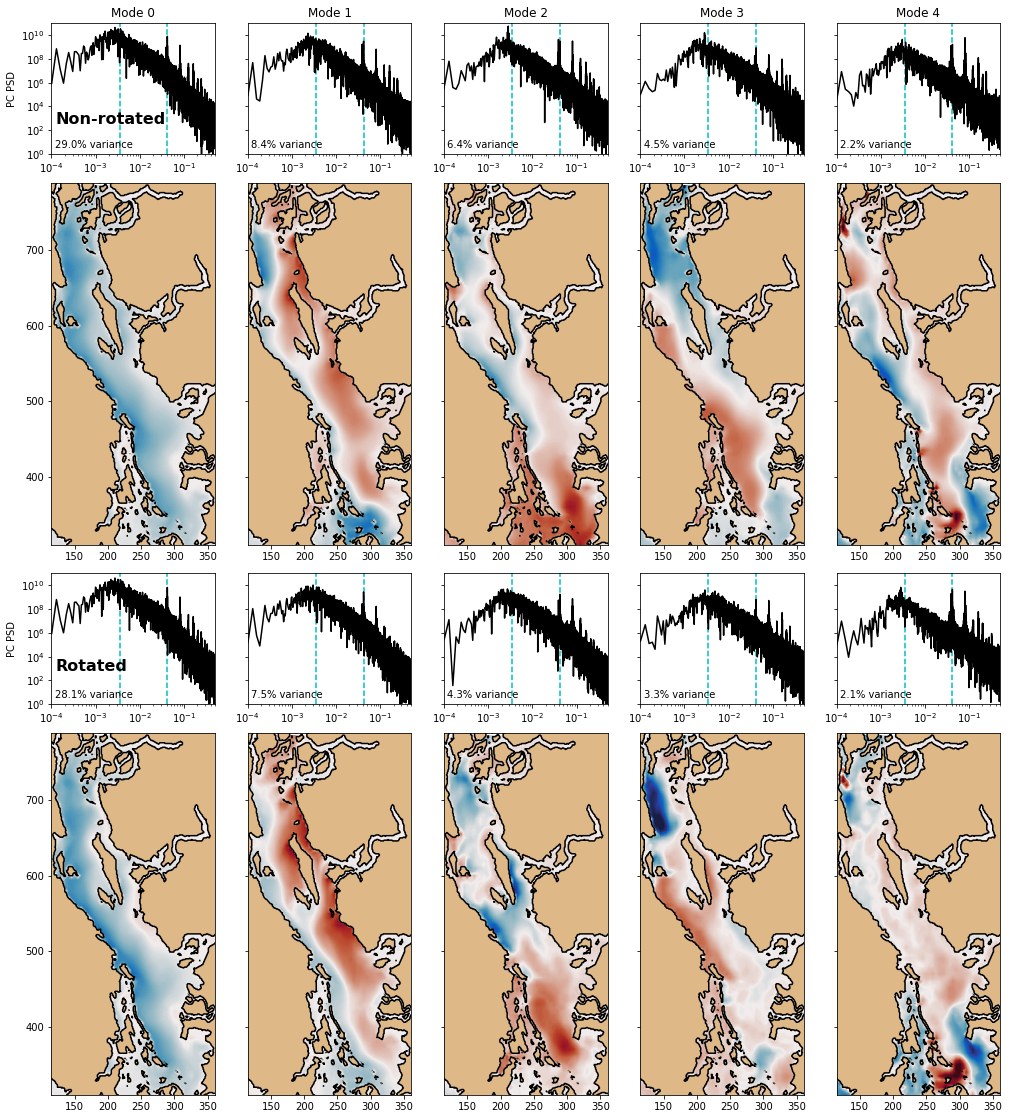

In [36]:
# 21 day cutoff
plot_EOF(EOF)

### 28 day cutoff

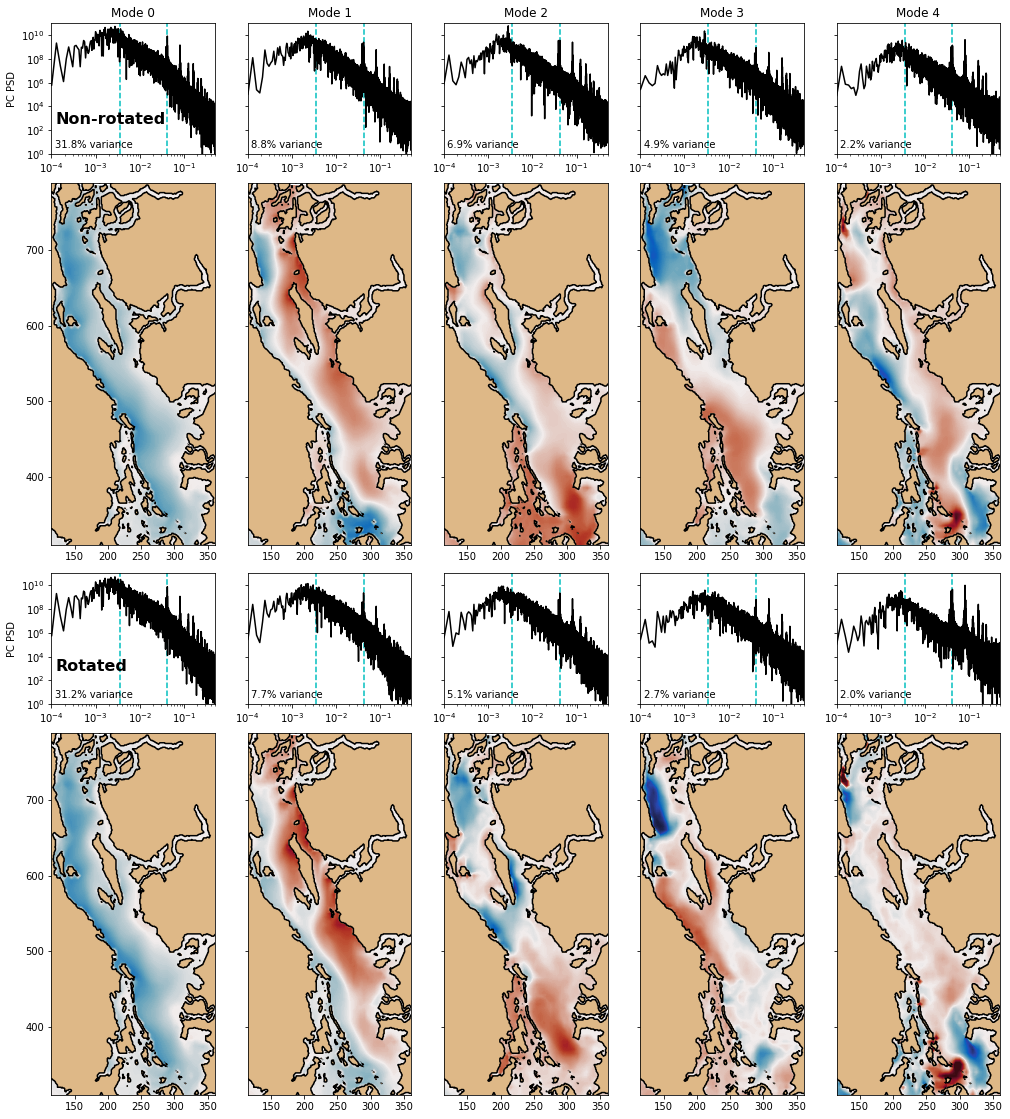

In [41]:
# 28 day cutoff
plot_EOF(EOF)

### 35 day cutoff

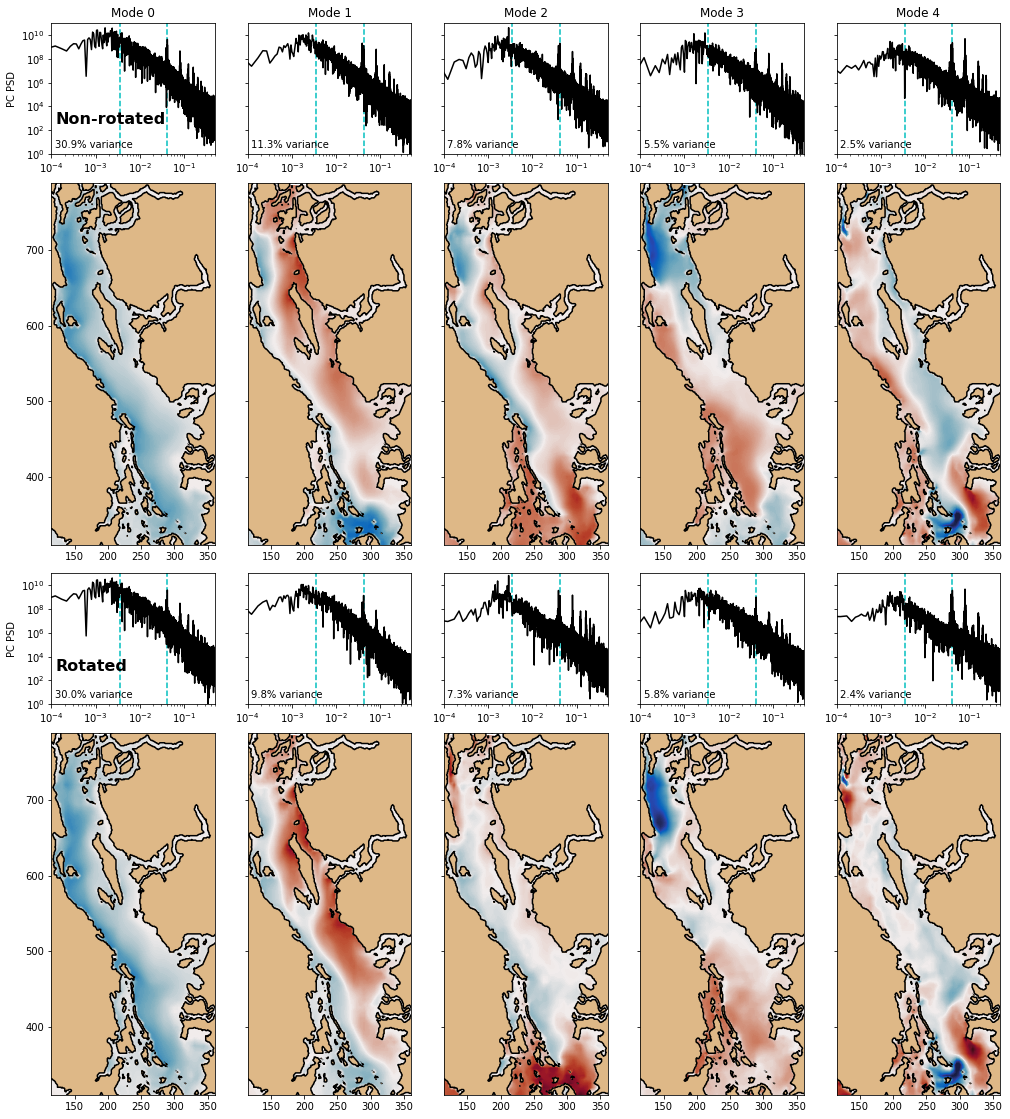

In [183]:
# 35 day cutoff
plot_EOF(EOF)

***

### Integrated wind diagnostic

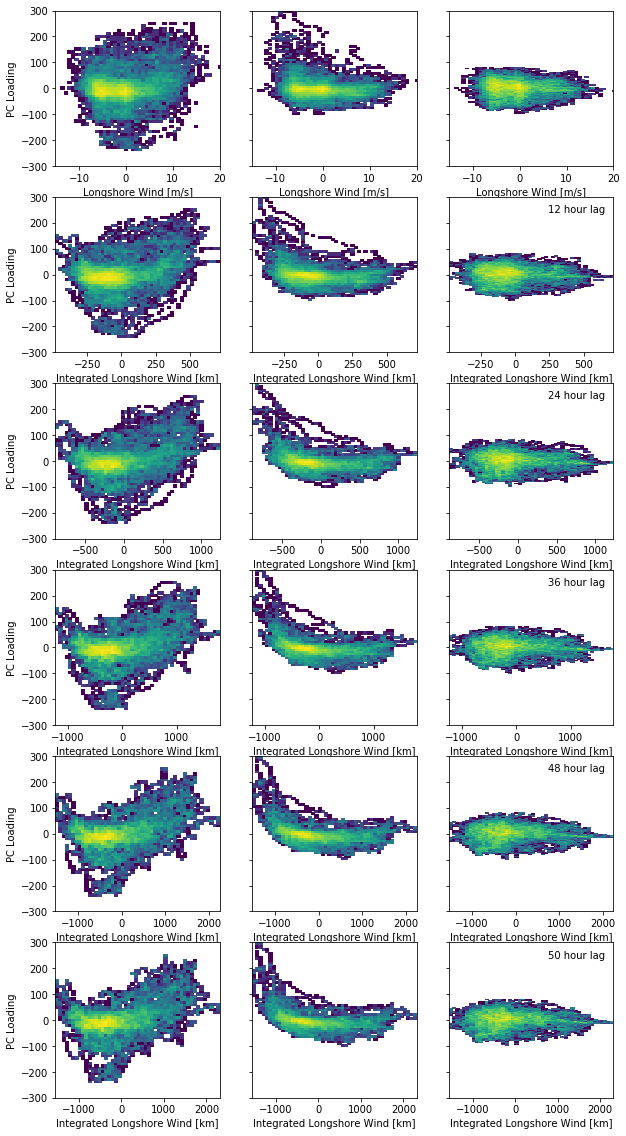

In [390]:
fig, axs = plt.subplots(6, 3, figsize=(10, 20))

# Find discontinuities
indices = [0] + list(np.where(np.diff(t) > timedelta(hours=1))[0] + 1) + [len(t)]

for ax, mode in zip(axs[0, :], range(3)):
    fac = -1 if mode == 0 else 1
    ax.hist2d(w, fac*EOF['B'][:, mode], bins=50, norm=mcolors.LogNorm())
    ax.set_xlim([-15, 20])
    ax.set_ylim([-300, 300])
    ax.set_xlabel('Longshore Wind [m/s]')
    if mode == 0: ax.set_ylabel('PC Loading')
    else: ax.yaxis.set_ticklabels('')

# Loop through plot rows
for row, lag in zip(axs[1:], [12, 24, 36, 48, 50]):
    
    # Construct integrated wind array
    w_int = np.empty(len(w))
    for n in range(len(indices) - 1):
        for i in range(*indices[n:n+2]):
            w_int[i] = sum(w[i-min(i, lag):i]) * 3600
    
    # Plot correlations
    for ax, mode in zip(row, range(3)):
        fac = -1 if mode == 0 else 1
        ax.hist2d(w_int*1e-3, fac*EOF['B'][:, mode], bins=50, norm=mcolors.LogNorm())
        #ax.set_xlim([-15, 20])
        ax.set_ylim([-300, 300])
        ax.set_xlabel('Integrated Longshore Wind [km]')
        if mode == 0: ax.set_ylabel('PC Loading')
        else: ax.yaxis.set_ticklabels('')
        if mode == 2: ax.text(0.6, 0.9, f'{lag} hour lag', transform=ax.transAxes)

***

### Summary Paper Figs

In [22]:
plt.rcParams['font.size'] = 10

EOF summary

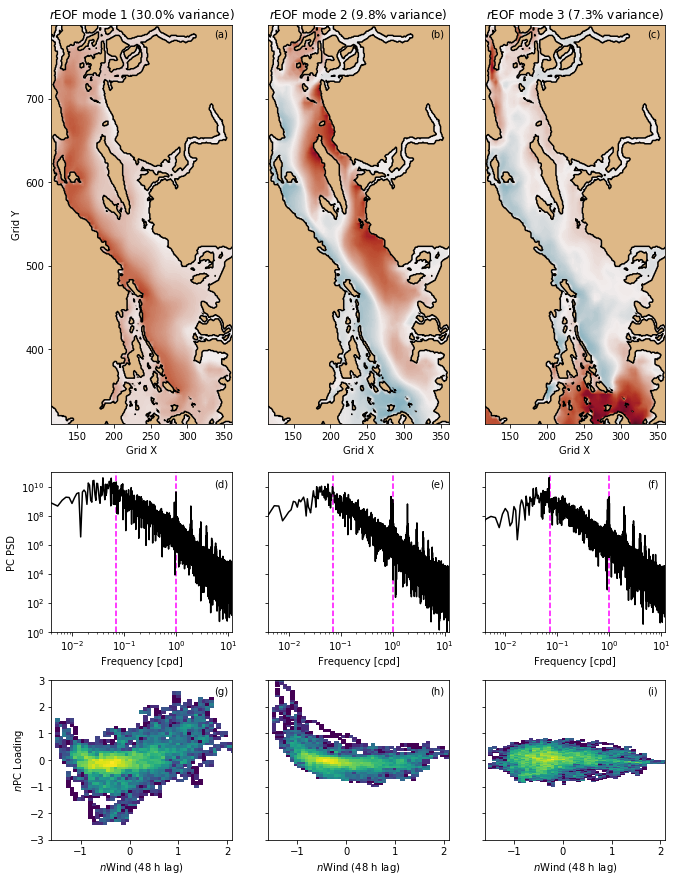

In [23]:
# Make figure and plotting params
fig, axs = plt.subplots(3, 3, figsize=(11, 15), gridspec_kw={'hspace': 0.2, 'height_ratios': [2.5, 1, 1]})

# Plot EOFs
plotx, ploty = mask.x[slice(*xrange, 5)], mask.y[slice(*yrange, 5)]
for ax, mode in zip(axs[0, :], range(3)):
    gridded = np.zeros(ptrc.nav_lon.shape)
    for y, x, val in zip(gridy, gridx, EOF['U'][:, mode]): gridded[y, x] = val
    fac = -1 if mode == 0 else 1
    ax.contourf(plotx, ploty, fac*gridded[::skip, ::skip], levels=np.arange(-0.1, 0.101, 0.001), cmap=cm.balance, extend='both')
    ax.contourf(mask.x, mask.y, mask.tmask[0, 0, ...], levels=[-0.01, 0.01], colors='Burlywood')
    ax.contour(mask.x, mask.y, mask.tmask[0, 0, ...], levels=[-0.01, 0.01], colors='k')
    viz_tools.set_aspect(ax)
    ax.set_xlim(xrange)
    ax.set_ylim(yrange)
    ax.set_xlabel('Grid X')
    if mode == 0: ax.set_ylabel('Grid Y')
    else: ax.yaxis.set_ticklabels('')
    ax.set_title(f"$r$EOF mode {mode+1} ({EOF['var_rot'][mode]*100:.01f}% variance)")
    ax.text(0.9, 0.97, f'({chr(mode + 97)})', transform=ax.transAxes)

# Plot PCs
xlim, ylim = [4e-3, 12], [1, 1e11]
freq = np.linspace(-12, 12, EOF['A'].shape[0])
for ax, mode in zip(axs[1, :], range(3)):
    for peak in [1, 14]: ax.plot([1/peak, 1/peak], ylim, '--', color='magenta')
    PSD = abs(fftshift(fft(EOF['A'][:, mode])))**2
    ax.plot(freq, PSD, 'k-')
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_xlabel('Frequency [cpd]')
    if mode == 0: ax.set_ylabel('PC PSD')
    else: ax.yaxis.set_ticklabels('')
    ax.text(0.9, 0.91, f'({chr(mode + 100)})', transform=ax.transAxes)

# Plot wind correlation
indices = [0] + list(np.where(np.diff(t) > timedelta(hours=1))[0] + 1) + [len(t)]
w_int = np.empty(len(w))
for n in range(len(indices) - 1):
    for i in range(*indices[n:n+2]):
        w_int[i] = sum(w[i-min(i, 48):i]) * 3600
for ax, mode in zip(axs[2, :], range(3)):
    fac = -1 if mode == 0 else 1
    ax.hist2d(w_int[48:]*1e-6, fac*EOF['B'][48:, mode]/100, bins=50, norm=mcolors.LogNorm())
    ax.set_xlim([-1.6, 2.1])
    ax.set_ylim([-3, 3])
    ax.set_xlabel('$n$Wind (48 h lag)')
    if mode == 0: ax.set_ylabel('$n$PC Loading')
    else: ax.yaxis.set_ticklabels('')
    ax.text(0.9, 0.91, f'({chr(mode + 103)})', transform=ax.transAxes)

PC timeseries summary

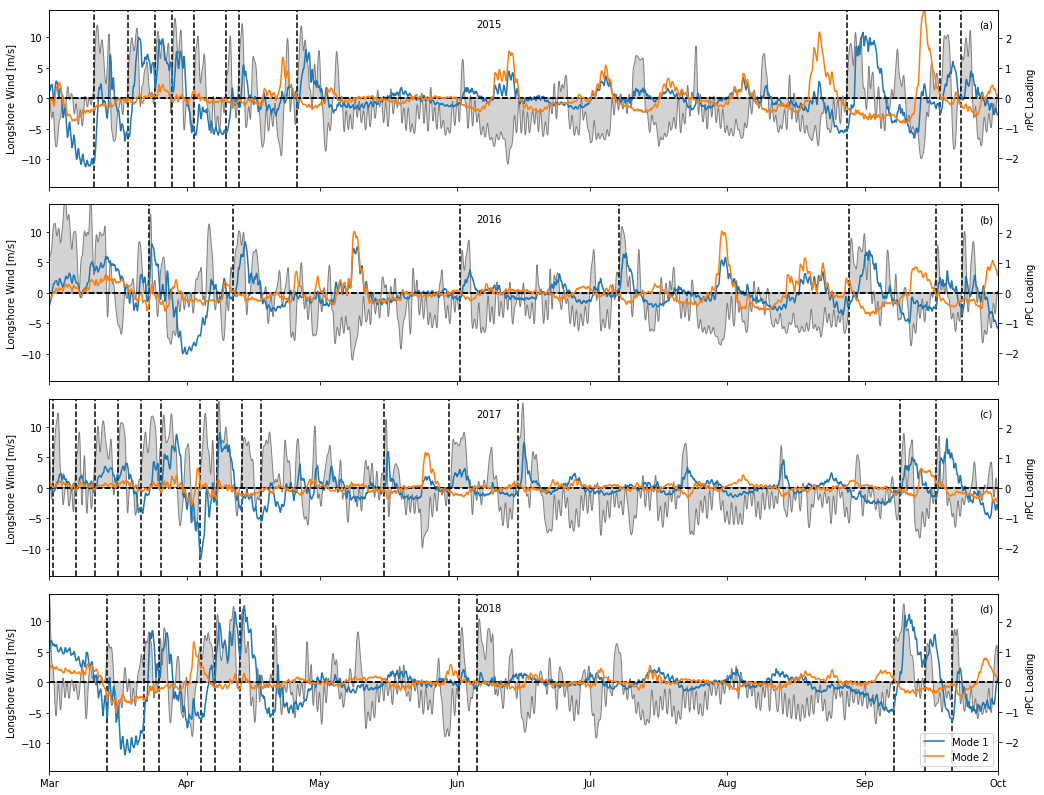

In [133]:
window = signal.get_window('blackman', 25)
window = window / sum(window)
wind_plot = signal.convolve(mag_axis, window, mode='same')

fig, axs = plt.subplots(4, 1, figsize=(17, 14), gridspec_kw={'hspace': 0.1})
for ax, year in zip(axs, range(2015, 2019)):
    xlim = [datetime(year, month, 1) for month in [3, 10]]
    ax.fill_between(time, wind_plot, facecolor='lightgray', edgecolor='gray')
    ax.set_xlim(xlim)
    ax.set_ylim([-14.5, 14.5])
    ax.set_ylabel('Longshore Wind [m/s]')
    ax2 = ax.twinx()
    ax2.set_ylim([-2.95, 2.95])
    ax2.set_ylabel('$n$PC Loading')
    for mode, fac in zip(range(2), [-1, 1]):
        ax2.plot(xlim, [0, 0], 'k--')
        ax2.plot(t, fac*EOF['B'][:, mode]/100, label=f'Mode {mode+1}')
    ax.xaxis.set_major_locator(getattr(mdates, 'MonthLocator')())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
    if year < 2018: ax.xaxis.set_ticklabels('')
    ax.text(0.98, 0.9, f'({chr(year - 1918)})', transform=ax.transAxes)
    ax.text(0.45, 0.9, str(year), transform=ax.transAxes)
    
    for event in events:
        if event.year == year:
            ax.plot([event, event], [-14.5, 14.5], 'k--')
ax2.legend(loc=4)

In [132]:
# Upwelling event date windows
events = [parse(date) for date in [
    '2015 Mar 11 04:00', #1
    '2015 Mar 18 17:00', #2
    '2015 Mar 24 22:00', #3
    '2015 Mar 28 18:00', #4
    '2015 Apr 02 17:00', #5
    '2015 Apr 09 20:00', #6
    '2015 Apr 12 18:00', #7
    '2015 Apr 25 23:00', #8
    '2015 Aug 28 00:00', #9
    '2015 Sep 18 00:00', #10
    '2015 Sep 22 16:00', #11
    '2016 Mar 23 10:00', #12
    '2016 Apr 11 13:00', #13
    '2016 Jun 01 18:00', #14
    '2016 Jul 07 14:00', #15
    '2016 Aug 28 12:00', #16
    '2016 Sep 17 02:00', #17
    '2016 Sep 22 20:00', #18
    '2017 Mar 01 20:00', #19
    '2017 Mar 06 23:00', #20
    '2017 Mar 11 07:00', #21
    '2017 Mar 16 12:00', #22
    '2017 Mar 21 15:00', #23
    '2017 Mar 26 08:00', #24
    '2017 Apr 03 23:00', #25
    '2017 Apr 07 19:00', #26
    '2017 Apr 13 12:00', #27
    '2017 Apr 17 18:00', #28
    '2017 May 15 12:00', #29
    '2017 May 30 04:00', #30
    '2017 Jun 14 17:00', #31
    '2017 Sep 08 23:00', #32
    '2017 Sep 17 02:00', #33
    '2017 Oct 21 05:00', #34
    '2018 Mar 14 00:00', #35
    '2018 Mar 22 07:00', #36
    '2018 Mar 25 19:00', #37
    '2018 Apr 04 08:00', #38
    '2018 Apr 07 07:00', #39
    '2018 Apr 12 23:00', #40
    '2018 Apr 20 12:00', #41
    '2018 Jun 01 12:00', #42
    '2018 Jun 05 12:00', #43
    '2018 Sep 07 13:00', #44
    '2018 Sep 14 13:00', #45
    '2018 Sep 20 17:00', #46
    '2018 Oct 23 06:00', #47
]]